In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('max_colwidth', 5000)
import pandas_profiling
from IPython.display import display
from feature_engine.categorical_encoders import OneHotCategoricalEncoder

In [2]:
from sklearn.model_selection import train_test_split as tts

In [3]:
df_backup = pd.read_csv('/Users/fayadabbasi/Desktop/Python_Scripts/Galvanize/DSI/CreditRisk/merged.csv', skiprows=1, low_memory=False)

In [4]:
df = df_backup.copy()

In [5]:
df = df[df.id!='id'] # leave behind those that do not have id in the id column
# due to csv merge, need to eliminate rows with redundant index; 16 of these

In [6]:
df.loan_status.value_counts()

Fully Paid                                             1191125
Current                                                 868848
Charged Off                                             287174
Late (31-120 days)                                       20775
In Grace Period                                           9242
Late (16-30 days)                                         4826
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     42
Name: loan_status, dtype: int64

In [7]:
df = df[['loan_amnt','grade','emp_length','annual_inc','purpose','revol_util','home_ownership','term','int_rate','dti','loan_status']]

In [8]:
df.head(2)

,loan_amnt,grade,emp_length,annual_inc,purpose,revol_util,home_ownership,term,int_rate,dti,loan_status
0,5000,B,10+ years,24000,credit_card,83.7%,RENT,36 months,10.65%,27.65,Fully Paid
1,2500,C,< 1 year,30000,car,9.4%,RENT,60 months,15.27%,1,Charged Off


In [9]:
convert_to_numeric = ['loan_amnt','annual_inc','dti']
for items in convert_to_numeric:
    df[items] = pd.to_numeric(df[items])

In [48]:
def pre_processing(dataframe, date='2019-8-01'):
    def emp_length(dataframe,column='emp_length'):
        dataframe[column+'_int'] = dataframe[column]
        dataframe[column+'_int'] = dataframe[column+'_int'].str.replace('\+ years','')
        dataframe[column+'_int'] = dataframe[column+'_int'].str.replace('< 1 year',str(0))
        dataframe[column+'_int'] = dataframe[column+'_int'].str.replace('n\a',str(0))
        dataframe[column+'_int'] = dataframe[column+'_int'].str.replace(' years','')
        dataframe[column+'_int'] = dataframe[column+'_int'].str.replace(' year','')
        dataframe[column+'_int'] = pd.to_numeric(dataframe[column+'_int'])
        dataframe[column+'_int'].fillna(0, inplace=True)
    
    def term_length(dataframe, column='term'):
        dataframe[column+'_int'] = dataframe[column]
        dataframe[column+'_int'] = dataframe[column].str.replace(' months','')
        dataframe[column+'_int'] = pd.to_numeric(dataframe[column+'_int'])
    
    def perc_convert(dataframe, column):
        dataframe[column+'_t'] = dataframe[column].fillna(str('0'))
        dataframe[column+'_factor'] = dataframe[column+'_t'].map(lambda x: str(x).rstrip('%').strip())
        dataframe[column+'_factor'] = pd.to_numeric(dataframe[column+'_factor'])
    
    emp_length(dataframe)
    term_length(dataframe)
    perc_convert(dataframe, column='int_rate')
    perc_convert(dataframe, column='revol_util')

    dataframe['annual_inc'].fillna(dataframe['annual_inc'].mean(), inplace=True)
    dataframe['dti'] = dataframe['dti'].fillna(dataframe['loan_amnt']/dataframe['annual_inc']*100)
    dataframe['good_bad'] = np.where(dataframe['loan_status'].isin(['Charged Off','Default','Does not meet the credit policy. Status:Fully Paid','Does not meet the credit policy. Status:Charged Off','Late (31-120 days)','Late (16-30 days)']),0,1)
    
    return dataframe

In [11]:
df = pre_processing(df)

In [12]:
df.head(2)

,loan_amnt,grade,emp_length,annual_inc,purpose,revol_util,home_ownership,term,int_rate,dti,loan_status,emp_length_int,term_int,int_rate_t,int_rate_factor,revol_util_t,revol_util_factor,good_bad
0,5000.0,B,10+ years,24000.0,credit_card,83.7%,RENT,36 months,10.65%,27.65,Fully Paid,10.0,36.0,10.65%,10.65,83.7%,83.7,1
1,2500.0,C,< 1 year,30000.0,car,9.4%,RENT,60 months,15.27%,1.00,Charged Off,0.0,60.0,15.27%,15.27,9.4%,9.4,0


In [13]:
df = df.drop(['emp_length','term','int_rate','int_rate_t','revol_util','revol_util_t'], axis=1)

In [23]:
def missing_values(dataframe,column):
    dataframe = dataframe[dataframe[column].notnull()]
    return dataframe

In [24]:
df = missing_values(df,'loan_amnt') 

In [49]:
# df['dti'] = df['dti'].fillna(df['loan_amnt']/df['annual_inc']*100)
# I ran this out of the original but then added it to the preprocessing file

In [50]:
def null_values(d):
    mis_valu = d.isnull().sum()
    mis_val_percent = 100* d.isnull().sum() / len(d)
    mis_val_table = pd.concat([mis_valu, mis_val_percent],axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns={0: 'Missing Values', 1: '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1]!=0].sort_values('% of Total Values', ascending=False).round(1)
    print("Dataframe has " + str(d.shape[1]) + " columns.\nThere are "+ str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
    return mis_val_table_ren_columns

In [51]:
miss_values = null_values(df)

Dataframe has 12 columns.
There are 0 columns that have missing values.


In [47]:
df.head(2)

,loan_amnt,grade,annual_inc,purpose,home_ownership,dti,loan_status,emp_length_int,term_int,int_rate_factor,revol_util_factor,good_bad
0,5000.0,B,24000.0,credit_card,RENT,27.65,Fully Paid,10.0,36.0,10.65,83.7,1
1,2500.0,C,30000.0,car,RENT,1.00,Charged Off,0.0,60.0,15.27,9.4,0


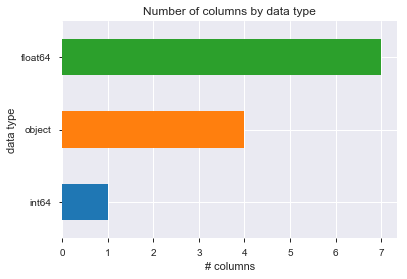

In [53]:
df.dtypes.value_counts().sort_values().plot(kind='barh')
plt.title('Number of columns by data type')
plt.xlabel("# columns")
plt.ylabel("data type");

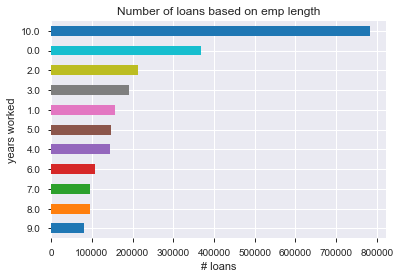

In [54]:
df['emp_length_int'].value_counts().sort_values().plot(kind='barh')
plt.title('Number of loans based on emp length')
plt.xlabel('# loans')
plt.ylabel('years worked');

In [55]:
lst = ['grade','home_ownership','purpose','emp_length_int','term_int']
def loan_data_d(dataframe, lst = []):
    for items in lst:
        loan_data_dummies = [pd.get_dummies(dataframe[items], prefix=items,prefix_sep=':')]
        loan_data_dummies = pd.concat(loan_data_dummies, axis=1)
        dataframe = pd.concat([dataframe, loan_data_dummies], axis = 1)
    return dataframe

In [56]:
df = loan_data_d(df,lst)

In [67]:
df = df.drop(lst, axis=1)

In [74]:
df.head(2)

,loan_amnt,annual_inc,dti,loan_status,int_rate_factor,revol_util_factor,good_bad,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,emp_length_int:0.0,emp_length_int:1.0,emp_length_int:2.0,emp_length_int:3.0,emp_length_int:4.0,emp_length_int:5.0,emp_length_int:6.0,emp_length_int:7.0,emp_length_int:8.0,emp_length_int:9.0,emp_length_int:10.0,term_int:36.0,term_int:60.0
0,5000.0,24000.0,27.65,Fully Paid,10.65,83.7,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,2500.0,30000.0,1.00,Charged Off,15.27,9.4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [146]:
df_inputs_prepr['annual_inc'].nunique()

77515

In [73]:
# df = df.drop(['loan_amnt_factor'], axis=1)

In [59]:
df['loan_status'].value_counts() / df['loan_status'].count()

Fully Paid                                             0.499469
Current                                                0.364330
Charged Off                                            0.120419
Late (31-120 days)                                     0.008711
In Grace Period                                        0.003875
Late (16-30 days)                                      0.002024
Does not meet the credit policy. Status:Fully Paid     0.000834
Does not meet the credit policy. Status:Charged Off    0.000319
Default                                                0.000018
Name: loan_status, dtype: float64

### Create Train Test Split

In [60]:
loan_data_input_train, loan_data_input_test, loan_data_target_train, loan_data_target_test = tts(df.drop(['loan_status','good_bad'], axis=1), df['good_bad'], test_size=0.25, random_state=42)

In [71]:
df_inputs_prepr, df_targets_prepr = loan_data_input_train, loan_data_target_train

In [69]:
#df['loan_amnt_factor'] = pd.cut(df['loan_amnt'],20)
#df['loan_amnt_factor:1'] = np.where((df['loan_amnt_factor'].isin(range())),1,0)

In [70]:
def woe_ordered_continuous(df, discrete_variable_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variable_name], good_bad_variable_df],axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].count(),df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].mean()], axis=1)
    df = df.iloc[:,[0,1,3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1-df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good']/ df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    # df = df.sort_values(['WoE'])
    # df = df.reset_index(drop=True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [123]:
df_inputs_prepr['loan_amnt_factor'] = pd.cut(df_inputs_prepr['loan_amnt'],30)
#df_inputs_prepr['loan_amnt_factor'] = pd.cut(df_inputs_prepr['loan_amnt'],5).astype(str)

In [117]:
# df_inputs_prepr.groupby(df_inputs_prepr['loan_amnt_factor']).count()

In [112]:
df_inputs_prepr.loan_amnt_factor[0].replace('(','').replace(']','').replace(' ','').split(',')[1]

'6425.0'

In [124]:
df_temp = woe_ordered_continuous(df_inputs_prepr,'loan_amnt_factor',df_targets_prepr)
df_temp

,loan_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(460.5, 1816.667]",22280,0.909246,0.012457,20258.0,2022.0,0.013052,0.008552,0.422808,NaN,NaN,0.031895
1,"(1816.667, 3133.333]",61094,0.893590,0.034158,54593.0,6501.0,0.035173,0.027494,0.246295,0.015656,0.176513,0.031895
2,"(3133.333, 4450.0]",61247,0.887717,0.034243,54370.0,6877.0,0.035029,0.029084,0.185975,0.005873,0.060320,0.031895
3,"(4450.0, 5766.667]",111706,0.885736,0.062455,98942.0,12764.0,0.063746,0.053982,0.166250,0.001981,0.019725,0.031895
4,"(5766.667, 7083.333]",119687,0.887030,0.066917,106166.0,13521.0,0.068400,0.057184,0.179105,0.001295,0.012855,0.031895
5,"(7083.333, 8400.0]",107454,0.873453,0.060078,93856.0,13598.0,0.060469,0.057509,0.050184,0.013578,0.128921,0.031895
6,"(8400.0, 9716.667]",60820,0.871868,0.034005,53027.0,7793.0,0.034164,0.032958,0.035921,0.001585,0.014264,0.031895
7,"(9716.667, 11033.333]",200095,0.878378,0.111873,175759.0,24336.0,0.113237,0.102923,0.095502,0.006510,0.059582,0.031895
8,"(11033.333, 12350.0]",123226,0.856597,0.068896,105555.0,17671.0,0.068006,0.074735,-0.094348,0.021781,0.189850,0.031895
9,"(12350.0, 13666.667]",46806,0.857454,0.026169,40134.0,6672.0,0.025857,0.028218,-0.087351,0.000857,0.006997,0.031895


In [120]:
def plot_by_woe(df_WoE, rotation_of_x_axis_label=0):
    x = np.array(df_WoE.iloc[:,0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18,6))
    plt.plot(x,y,marker='o', linestyle='--',color='k')
    plt.xlabel = (df_WoE.columns[0])
    plt.ylabel = ('Weight of Evidence')
    plt.title(str('Weight of Evidence by '+ df_WoE.columns[0]))
    plt.xticks(rotation=rotation_of_x_axis_label)

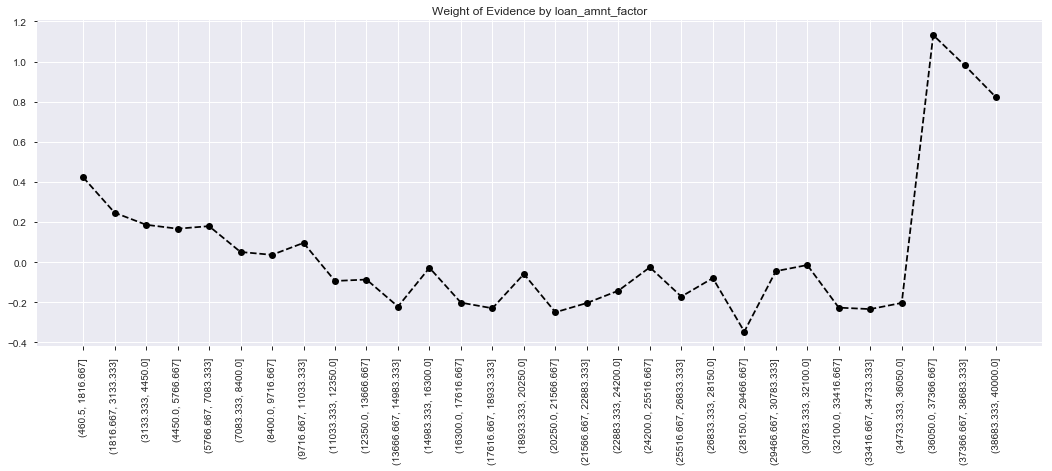

In [125]:
plot_by_woe(df_temp, 90)

In [127]:
df_inputs_prepr['loan_amnt_factor:1'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(1817))),1,0)
df_inputs_prepr['loan_amnt_factor:2'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(1817,7084))),1,0)
df_inputs_prepr['loan_amnt_factor:3'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(7084,11034))),1,0)
df_inputs_prepr['loan_amnt_factor:4'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(11034,28150))),1,0)
df_inputs_prepr['loan_amnt_factor:5'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(28150,28160))),1,0)
df_inputs_prepr['loan_amnt_factor:6'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(28160,32100))),1,0)
df_inputs_prepr['loan_amnt_factor:7'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(32100,36050))),1,0)
df_inputs_prepr['loan_amnt_factor:8'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(36050,int(df_inputs_prepr['loan_amnt'].max())))),1,0)

In [97]:
df_inputs_prepr.head(2)

,loan_amnt,grade,annual_inc,purpose,home_ownership,dti,emp_length_int,term_int,int_rate_factor,revol_util_factor,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,emp_length_int:0.0,emp_length_int:1.0,emp_length_int:2.0,emp_length_int:3.0,emp_length_int:4.0,emp_length_int:5.0,emp_length_int:6.0,emp_length_int:7.0,emp_length_int:8.0,emp_length_int:9.0,emp_length_int:10.0,term_int:36.0,term_int:60.0,loan_amnt_factor,loan_amnt_factor:1
1378684,32000.0,C,94000.0,credit_card,MORTGAGE,22.90,10.0,60.0,15.99,75.8,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,"(30125.0, 32100.0]",0
1047648,14400.0,C,60000.0,debt_consolidation,MORTGAGE,16.18,6.0,60.0,11.99,12.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,"(14325.0, 16300.0]",0


In [109]:
df_inputs_prepr.loan_amnt_factor[0].replace('(','').replace(']','').replace(' ','').split(',')

['4450.0', '6425.0']

In [147]:
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'],100)

In [150]:
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['annual_inc']<140000,:]

In [158]:
df_inputs_prepr_temp['annual_inc_factor'] = pd.cut(df_inputs_prepr_temp['annual_inc'],20)

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [159]:
df_temp = woe_ordered_continuous(df_inputs_prepr_temp,'annual_inc_factor',df_targets_prepr[df_inputs_prepr_temp.index])
df_temp

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-139.999, 6999.95]",2642,0.921650,0.001619,2435.0,207.0,0.001727,0.000933,0.615973,NaN,NaN,0.023823
1,"(6999.95, 13999.9]",7808,0.846952,0.004785,6613.0,1195.0,0.004691,0.005385,-0.138119,0.074698,0.754092,0.023823
2,"(13999.9, 20999.85]",25426,0.838708,0.015582,21325.0,4101.0,0.015126,0.018481,-0.200361,0.008243,0.062242,0.023823
3,"(20999.85, 27999.8]",53860,0.837579,0.033007,45112.0,8748.0,0.031997,0.039423,-0.208687,0.001130,0.008326,0.023823
4,"(27999.8, 34999.75]",93435,0.839086,0.057260,78400.0,15035.0,0.055608,0.067755,-0.197567,0.001507,0.011120,0.023823
5,"(34999.75, 41999.7]",154114,0.845186,0.094446,130255.0,23859.0,0.092389,0.107520,-0.151678,0.006100,0.045889,0.023823
6,"(41999.7, 48999.65]",150516,0.848308,0.092241,127684.0,22832.0,0.090565,0.102892,-0.127615,0.003122,0.024063,0.023823
7,"(48999.65, 55999.6]",187025,0.855688,0.114615,160035.0,26990.0,0.113511,0.121630,-0.069084,0.007379,0.058531,0.023823
8,"(55999.6, 62999.55]",153143,0.858910,0.093851,131536.0,21607.0,0.093297,0.097372,-0.042747,0.003222,0.026337,0.023823
9,"(62999.55, 69999.5]",120460,0.863980,0.073822,104075.0,16385.0,0.073819,0.073839,-0.000265,0.005070,0.042482,0.023823


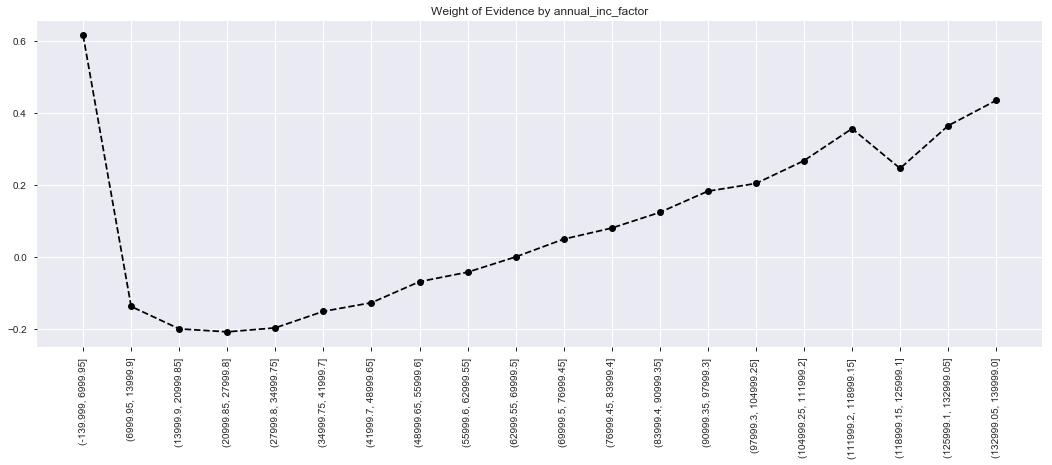

In [160]:
plot_by_woe(df_temp, 90)

In [161]:
df_inputs_prepr['annual_inc_factor:1'] = np.where((df_inputs_prepr['annual_inc_factor'].isin(range(7000))),1,0)
df_inputs_prepr['annual_inc_factor:2'] = np.where((df_inputs_prepr['annual_inc_factor'].isin(range(7000,42000))),1,0)
df_inputs_prepr['annual_inc_factor:3'] = np.where((df_inputs_prepr['annual_inc_factor'].isin(range(42000,70000))),1,0)
df_inputs_prepr['annual_inc_factor:4'] = np.where((df_inputs_prepr['annual_inc_factor'].isin(range(70000,100000))),1,0)
df_inputs_prepr['annual_inc_factor:5'] = np.where((df_inputs_prepr['annual_inc_factor'].isin(range(100000,112000))),1,0)
df_inputs_prepr['annual_inc_factor:6'] = np.where((df_inputs_prepr['annual_inc_factor'].isin(range(112000,126000))),1,0)
df_inputs_prepr['annual_inc_factor:7'] = np.where((df_inputs_prepr['annual_inc_factor'].isin(range(126000,int(df_inputs_prepr['annual_inc'].max())))),1,0)

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [62]:
from sklearn import linear_model
import scipy.stats as stat

In [63]:
class LogisticRegression_with_p_values:
    """
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient in 

    self.z_scores
    self.p_values
    self.sigma_estimates

    as well as the negative hessian of the log Likelihood (Fisher information)

    self.F_ij
    """
    def __init__(self, *args, **kwargs):
        self.model = linear_model.LogisticRegression(*args, **kwargs)
    def fit(self, X, y):
        self.model.fit(X,y)
        # Get p-values for the fitted model
        denom = (2.0 * (1 + np.cosh(self.model.decision_function(X)))) #desc_func predicts confidence score
        denom = np.tile(denom,(X.shape[1], 1)).T
        F_ij = np.dot((X / denom).T,X) # Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) # Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] # two tailed test for p-values
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [65]:
print("input train shape: {} \ntargets train shape: {}".format(loan_data_input_train.shape, loan_data_target_train.shape))

input train shape: (1788585, 50) 
targets train shape: (1788585,)


In [66]:
print("inputs test shape: {} \ntargets test shape: {}".format(loan_data_input_test.shape, loan_data_target_test.shape))

inputs test shape: (596196, 50) 
targets test shape: (596196,)


In [ ]:
ref_categories = ['grade:G','home_ownership:RENT','verification_status:Verified','loan_status:Late (31-120 days)','purpose:wedding','addr_state:WY','initial_list_status:w','emp_length:10']